## Mise en place

In [3]:
import pandas as pd
import numpy as np
import gini

from util_data import DataSet

from sklearn.neighbors import KNeighborsRegressor

data = DataSet()

In [4]:
training_set = data.get_training_set(25000).as_matrix()
testing_set = data.get_training_set(15000).as_matrix()

Ytr, Xtr = training_set[:,1],training_set[:,2:]
Ytst, Xtst = testing_set[:,1],testing_set[:,2:]

## Entrainement et Prédiction

In [5]:
clf = KNeighborsRegressor(n_neighbors=15,weights='distance')
clf.fit(Xtr,Ytr)

Ypred = clf.predict(Xtst)

## Analyse

Gini: 0.042, Max. Gini: 0.481, Normalized Gini: 0.088


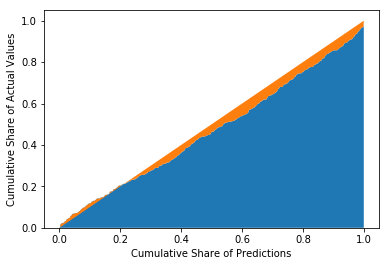

In [6]:
gini.gini_visualization(Ytst,Ypred,True)